In [1]:
import pandas as pd
import numpy as np
from optbinning import BinningProcess


In [2]:
df_master = pd.read_csv('merged_kpi_dataset_v2.csv')

### 데이터 수정

In [3]:
# 집계된 bureau 파일 불러오기
agg_bureau = pd.read_csv("agg_bureau.csv")

# app 기준 ID 추출
valid_ids = set(df_master["SK_ID_CURR"])
agg_bureau_filtered = agg_bureau[agg_bureau["SK_ID_CURR"].isin(valid_ids)].copy()

# 겹치는 컬럼 확인
common_cols = list(set(agg_bureau_filtered.columns) & set(df_master.columns))
common_cols.remove("SK_ID_CURR")  # ID는 남겨야 함

# 덮어쓰기 위해 기존 컬럼 제거
if common_cols:
    df_master.drop(columns=common_cols, inplace=True)

# 병합 (덮어쓰기 처리됨)
df_master = df_master.merge(agg_bureau_filtered, on="SK_ID_CURR", how="left")


# 새 DPD 데이터
dpd_merged = pd.read_csv("SK_AVG_DPD.csv")

# 병합 (SK_ID_CURR 기준)
df_master = df_master.merge(dpd_merged, on="SK_ID_CURR", how="left")



In [4]:
# 세 컬럼 모두 0인 경우 1, 아니면 0 → 거래내역 없음 플래그
cols = ['CREDIT_CARD_HISTORY_YEARS', 'LOAN_HISTORY_YEARS', 'LOAN_HISTORY_YEARS(prev)']
df_master['NO_CREDIT_HISTORY_FLAG'] = (df_master[cols].sum(axis=1) == 0).astype(int)

In [5]:
df_master['CC_90PLUS'] = (df_master['CC_90PLUS'] > 0).astype(int)

In [6]:
df_master = df_master.drop(['CARD_USAGE_BIN_5P', 'HAS_BAD_STATUS_36M',"AVG_SK_DPD_x", "AVG_SK_DPD_y"], axis = 1)

In [7]:
# 저장
df_master.to_csv("merged_kpi_dataset_v3.csv", index=False, encoding="utf-8-sig")
print("병합 완료 → 'merged_kpi_dataset_v3.csv'")

병합 완료 → 'merged_kpi_dataset_v3.csv'


-------

### 데이터 복사

In [8]:
merged = df_master.copy()

In [9]:
merged

,SK_ID_CURR,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,TARGET,CC_90PLUS,AVG_CARD_USAGE_MONTHS,AVG_UTIL_RATIO,AVG_MIN_PAY_RATIO,AVG_REPAY_RATIO,...,OVERLAP,OVERLAP_YEARS,HAS_HIGH_RISK_DEBT,CNT_EARLY_REPAID,CNT_REPAID_ON_TIME,CNT_OVERDUE_ENDED,CNT_NOT_ENDED,CREDIT_AVG_SK_DPD,POS_AVG_SK_DPD,NO_CREDIT_HISTORY_FLAG
0,100002,0.083037,0.262949,0.139376,1,0,NaN,NaN,NaN,NaN,...,6.0,9.200000,0.0,3.0,2.0,0.0,3.0,NaN,0.000000,0
1,100003,0.311267,0.622246,NaN,0,0,NaN,NaN,NaN,NaN,...,2.0,-1.032877,0.0,1.0,1.0,1.0,1.0,NaN,0.000000,0
2,100004,NaN,0.555912,0.729567,0,0,NaN,NaN,NaN,NaN,...,0.0,-0.512329,0.0,1.0,1.0,0.0,0.0,NaN,0.000000,0
3,100006,NaN,0.650442,NaN,0,0,6.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.000000,0
4,100007,NaN,0.322738,NaN,0,0,NaN,NaN,NaN,NaN,...,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,NaN,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0.145570,0.681632,NaN,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0
307507,456252,NaN,0.115992,NaN,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0
307508,456253,0.744026,0.535722,0.218859,0,0,NaN,NaN,NaN,NaN,...,3.0,7.013699,0.0,2.0,0.0,0.0,2.0,NaN,0.294118,0
307509,456254,NaN,0.514163,0.661024,1,0,NaN,NaN,NaN,NaN,...,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,NaN,0.000000,0


--------

### 참고용 ) 상관관계 확인

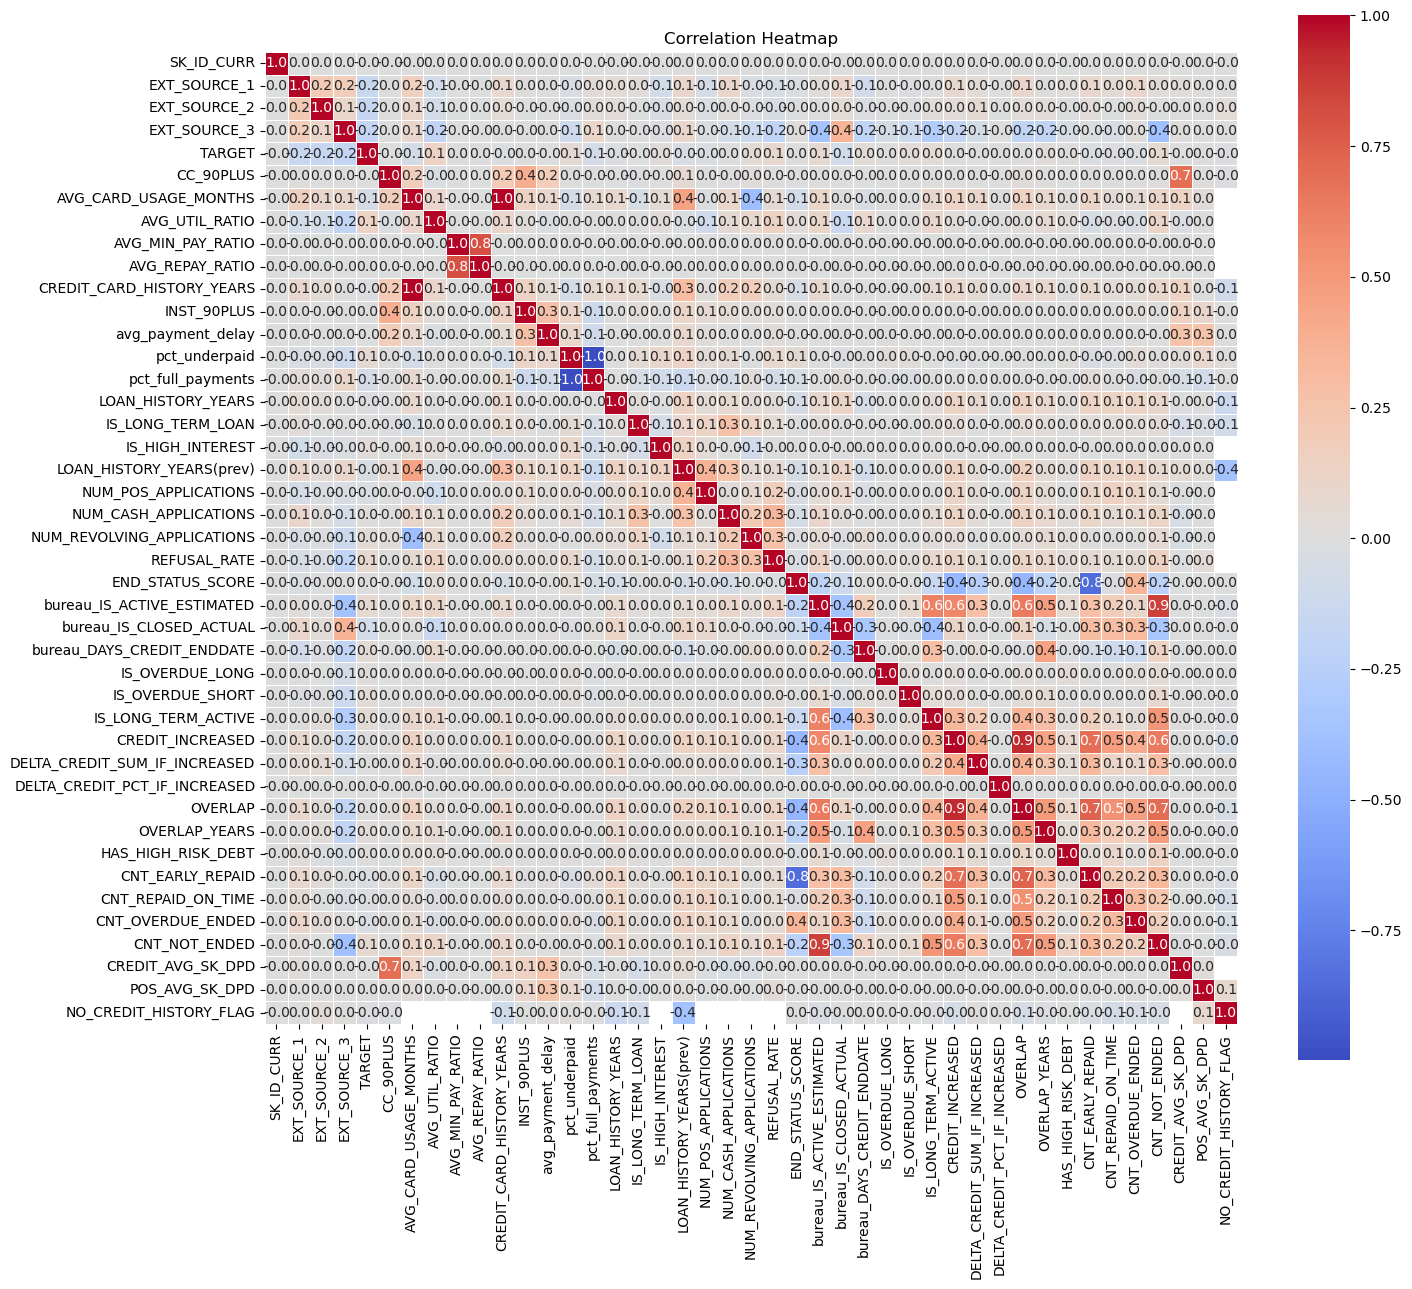

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 수치형 변수만 추출 (상관계수는 수치형 변수 간에만 의미 있음)
numeric_df = merged.select_dtypes(include=['number'])

# 2. 상관계수 계산
corr = numeric_df.corr()

# 3. 히트맵 그리기
plt.figure(figsize=(15, 13))
sns.heatmap(corr, annot=True, fmt=".1f", cmap='coolwarm', square=True, linewidths=0.5)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()


In [11]:
merged.corr()['TARGET'].abs().sort_values(ascending=False)

TARGET                           1.000000
EXT_SOURCE_3                     0.178919
EXT_SOURCE_2                     0.160472
EXT_SOURCE_1                     0.155317
AVG_UTIL_RATIO                   0.132842
bureau_IS_CLOSED_ACTUAL          0.077792
REFUSAL_RATE                     0.077671
CNT_NOT_ENDED                    0.067039
bureau_IS_ACTIVE_ESTIMATED       0.064042
pct_full_payments                0.063143
pct_underpaid                    0.062612
AVG_CARD_USAGE_MONTHS            0.061206
bureau_DAYS_CREDIT_ENDDATE       0.046982
NUM_REVOLVING_APPLICATIONS       0.045602
IS_LONG_TERM_ACTIVE              0.042567
LOAN_HISTORY_YEARS(prev)         0.041352
IS_OVERDUE_SHORT                 0.035850
OVERLAP_YEARS                    0.031417
CNT_OVERDUE_ENDED                0.026854
IS_HIGH_INTEREST                 0.026497
NUM_POS_APPLICATIONS             0.024506
CNT_EARLY_REPAID                 0.022981
CNT_REPAID_ON_TIME               0.022228
NO_CREDIT_HISTORY_FLAG           0

In [12]:
# 1. 상관계수 행렬에서 절댓값 기준으로 0.7 이상 & 자기 자신은 제외
high_corr = corr.abs()

# 2. 자기 자신 상관계수 제외 (1.0인 대각선 제거)
mask = np.triu(np.ones_like(high_corr, dtype=bool))
high_corr_filtered = high_corr.mask(mask)

# 3. 0.7 이상 필터링
high_corr_pairs = high_corr_filtered.stack()
high_corr_pairs = high_corr_pairs[high_corr_pairs >= 0.7].sort_values(ascending=False)

# 결과 출력
print("상관계수 절댓값이 0.7 이상인 변수쌍:")
print(high_corr_pairs)


상관계수 절댓값이 0.7 이상인 변수쌍:
pct_full_payments          pct_underpaid                 0.998953
CREDIT_CARD_HISTORY_YEARS  AVG_CARD_USAGE_MONTHS         0.997172
OVERLAP                    CREDIT_INCREASED              0.922918
CNT_NOT_ENDED              bureau_IS_ACTIVE_ESTIMATED    0.864562
CNT_EARLY_REPAID           END_STATUS_SCORE              0.848555
AVG_REPAY_RATIO            AVG_MIN_PAY_RATIO             0.809183
CNT_EARLY_REPAID           OVERLAP                       0.741022
CNT_NOT_ENDED              OVERLAP                       0.702135
dtype: float64


### 복사본 생성

In [13]:
df = merged.copy()

### WOE 계산하기 전 전처리 (결측치 처리 & binning)

In [14]:
df.columns

Index(['SK_ID_CURR', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'TARGET',
       'CC_90PLUS', 'AVG_CARD_USAGE_MONTHS', 'AVG_UTIL_RATIO',
       'AVG_MIN_PAY_RATIO', 'AVG_REPAY_RATIO', 'CREDIT_CARD_HISTORY_YEARS',
       'INST_90PLUS', 'avg_payment_delay', 'pct_underpaid',
       'pct_full_payments', 'LOAN_HISTORY_YEARS', 'IS_LONG_TERM_LOAN',
       'IS_HIGH_INTEREST', 'LOAN_HISTORY_YEARS(prev)', 'NUM_POS_APPLICATIONS',
       'NUM_CASH_APPLICATIONS', 'NUM_REVOLVING_APPLICATIONS', 'REFUSAL_RATE',
       'END_STATUS_SCORE', 'bureau_IS_ACTIVE_ESTIMATED',
       'bureau_IS_CLOSED_ACTUAL', 'bureau_DAYS_CREDIT_ENDDATE',
       'IS_OVERDUE_LONG', 'IS_OVERDUE_SHORT', 'IS_LONG_TERM_ACTIVE',
       'CREDIT_INCREASED', 'DELTA_CREDIT_SUM_IF_INCREASED',
       'DELTA_CREDIT_PCT_IF_INCREASED', 'OVERLAP', 'OVERLAP_YEARS',
       'HAS_HIGH_RISK_DEBT', 'CNT_EARLY_REPAID', 'CNT_REPAID_ON_TIME',
       'CNT_OVERDUE_ENDED', 'CNT_NOT_ENDED', 'CREDIT_AVG_SK_DPD',
       'POS_AVG_SK_DPD', 'NO_CREDIT_HIS

In [15]:
# 범주형 변수
cat_cols = [ 'CC_90PLUS',
 'IS_LONG_TERM_LOAN',
 'IS_HIGH_INTEREST',
 'NO_CREDIT_HISTORY_FLAG',
 'IS_OVERDUE_LONG',
 'IS_OVERDUE_SHORT',
 'IS_LONG_TERM_ACTIVE',
 'HAS_HIGH_RISK_DEBT']

# 연속형 변수
cont_cols = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'AVG_CARD_USAGE_MONTHS', 'AVG_UTIL_RATIO',
       'AVG_MIN_PAY_RATIO', 'AVG_REPAY_RATIO', 'CREDIT_CARD_HISTORY_YEARS',
       'INST_90PLUS', 'avg_payment_delay', 'pct_underpaid',
       'pct_full_payments', 'LOAN_HISTORY_YEARS', 'LOAN_HISTORY_YEARS(prev)', 'NUM_POS_APPLICATIONS',
       'NUM_CASH_APPLICATIONS', 'NUM_REVOLVING_APPLICATIONS', 'REFUSAL_RATE',
       'END_STATUS_SCORE', 'bureau_IS_ACTIVE_ESTIMATED',
       'bureau_IS_CLOSED_ACTUAL', 'bureau_DAYS_CREDIT_ENDDATE','CREDIT_INCREASED', 'DELTA_CREDIT_SUM_IF_INCREASED',
       'DELTA_CREDIT_PCT_IF_INCREASED', 'OVERLAP', 'OVERLAP_YEARS','CNT_EARLY_REPAID', 'CNT_REPAID_ON_TIME',
       'CNT_OVERDUE_ENDED', 'CNT_NOT_ENDED', 'CREDIT_AVG_SK_DPD',
       'POS_AVG_SK_DPD',
]

In [16]:
len(cat_cols + cont_cols)

41

### WOE 계산

In [17]:
def calc_woe(df, feature, target='TARGET', bins=10, treat_as_binary=False):
    import numpy as np
    import pandas as pd

    df_tmp = df[[feature, target]].copy()

    if treat_as_binary:
        # 이진 변수 처리
        df_tmp[feature] = df_tmp[feature].fillna('Missing')
        df_tmp['bin'] = df_tmp[feature]
        group = df_tmp.groupby('bin')[target]

    elif pd.api.types.is_numeric_dtype(df_tmp[feature]):
        df_tmp['bin'] = pd.qcut(df_tmp[feature], bins, duplicates='drop')
        if df_tmp[feature].isna().any():
            if 'Missing' not in df_tmp['bin'].cat.categories:
                df_tmp['bin'] = df_tmp['bin'].cat.add_categories('Missing')
            df_tmp.loc[df_tmp[feature].isna(), 'bin'] = 'Missing'
        group = df_tmp.groupby('bin')[target]

    else:
        df_tmp[feature] = df_tmp[feature].fillna('Missing')
        df_tmp['bin'] = df_tmp[feature]
        group = df_tmp.groupby('bin')[target]

    good = group.sum() + 0.5
    bad = group.count() - group.sum() + 0.5
    dist_good = good / good.sum()
    dist_bad = bad / bad.sum()
    woe = np.log(dist_good / dist_bad)
    woe_df = pd.DataFrame({
    'WOE': woe,
    'good': good,
    'bad': bad
})

    return woe_df


In [18]:
woe_results = {}

for feature in cont_cols:
    woe_df = calc_woe(df, feature, target='TARGET', bins=10)
    woe_results[feature] = woe_df

for feature in cat_cols:
    woe_df = calc_woe(df, feature, target='TARGET', treat_as_binary=True)
    woe_results[feature] = woe_df


/var/folders/sd/4fdm4yws541djlmflm16vjv40000gn/T/ipykernel_88688/1099311795.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group = df_tmp.groupby('bin')[target]
/var/folders/sd/4fdm4yws541djlmflm16vjv40000gn/T/ipykernel_88688/1099311795.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group = df_tmp.groupby('bin')[target]
/var/folders/sd/4fdm4yws541djlmflm16vjv40000gn/T/ipykernel_88688/1099311795.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the futu

/var/folders/sd/4fdm4yws541djlmflm16vjv40000gn/T/ipykernel_88688/1099311795.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group = df_tmp.groupby('bin')[target]
/var/folders/sd/4fdm4yws541djlmflm16vjv40000gn/T/ipykernel_88688/1099311795.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group = df_tmp.groupby('bin')[target]
/var/folders/sd/4fdm4yws541djlmflm16vjv40000gn/T/ipykernel_88688/1099311795.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the futu

In [19]:
i = 1
for feature, woe_df in woe_results.items():
    print(f"=== {i}. {feature} ===")
    i += 1
    print(woe_df)
    print()


=== 1. EXT_SOURCE_1 ===
                                    WOE     good       bad
bin                                                       
(0.013600000000000001, 0.213]  0.886262   2356.5   11058.5
(0.213, 0.296]                 0.401036   1555.5   11858.5
(0.296, 0.369]                 0.130559   1220.5   12194.5
(0.369, 0.438]                 0.040958   1124.5   12288.5
(0.438, 0.506]                -0.201873    898.5   12517.5
(0.506, 0.573]                -0.314345    808.5   12604.5
(0.573, 0.64]                 -0.483034    689.5   12724.5
(0.64, 0.71]                  -0.649330    588.5   12825.5
(0.71, 0.787]                 -0.880069    471.5   12942.5
(0.787, 0.963]                -1.200760    345.5   13069.5
Missing                        0.058551  14771.5  158607.5

=== 2. EXT_SOURCE_2 ===
                             WOE    good      bad
bin                                              
(-0.0009999183, 0.216]  0.939566  5631.5  25055.5
(0.216, 0.34]           0.447294  

### WOE 그래프

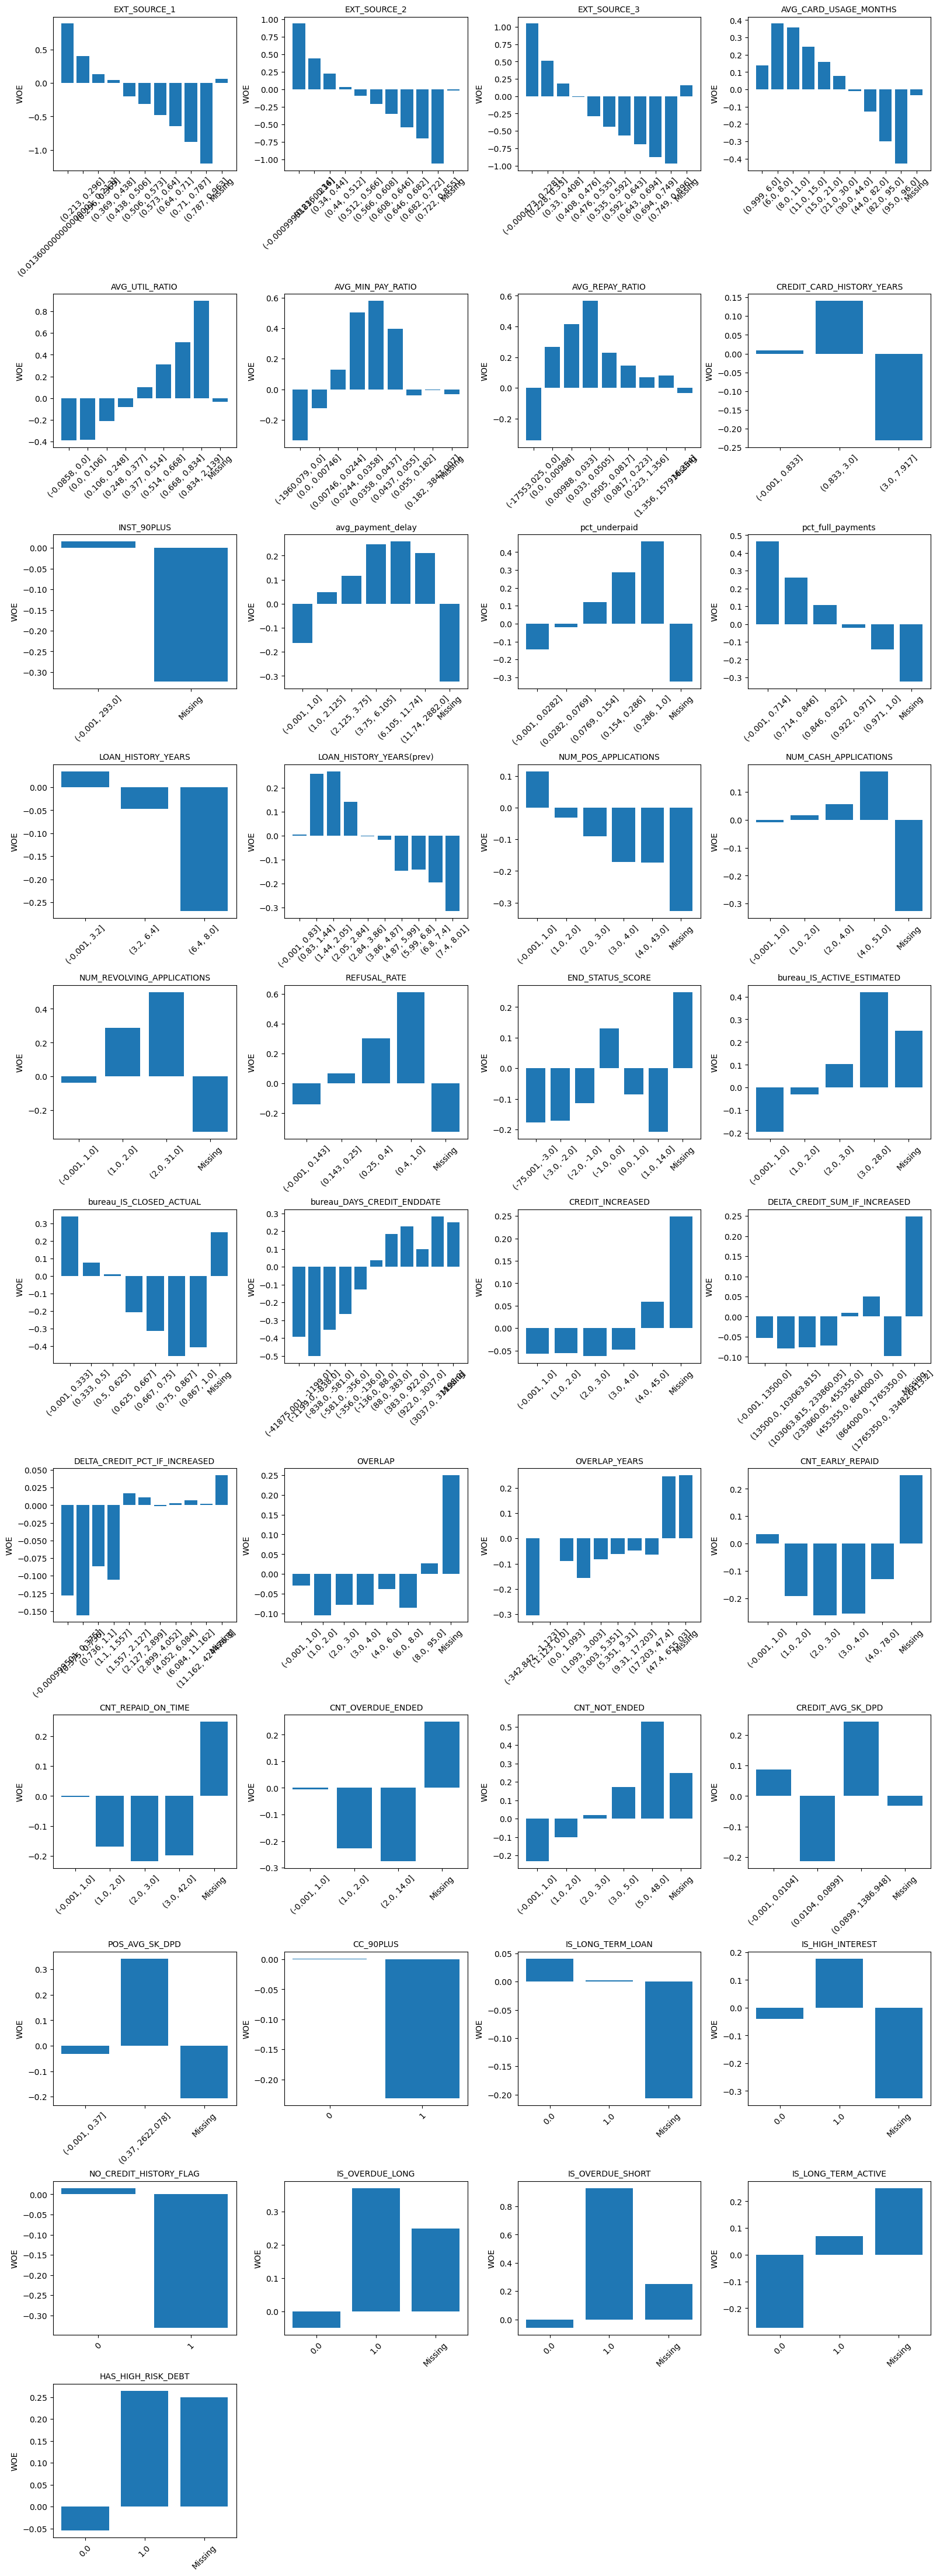

In [20]:
import matplotlib.pyplot as plt
import math

features = list(woe_results.keys())
n_features = len(features)

ncols = 4
nrows = math.ceil(n_features / ncols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4 * ncols, 4 * nrows), constrained_layout=True)

for idx, feature in enumerate(features):
    row = idx // ncols
    col = idx % ncols
    ax = axes[row, col] if nrows > 1 else axes[col]  # nrows=1일 때 axes 1차원 처리

    woe_df = woe_results[feature].copy()
    woe_df.index = woe_df.index.astype(str)

    ax.bar(woe_df.index, woe_df['WOE'])
    ax.set_title(feature, fontsize=10)
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylabel('WOE')

# 빈 subplot 숨기기
total_plots = nrows * ncols
for idx in range(n_features, total_plots):
    row = idx // ncols
    col = idx % ncols
    ax = axes[row, col] if nrows > 1 else axes[col]
    ax.axis('off')

plt.show()


--------

### IV 계산

In [21]:
def calc_woe_iv(df, feature, target='TARGET', bins=10):
    import numpy as np
    import pandas as pd

    df_tmp = df[[feature, target]].copy()

    is_binary = pd.api.types.is_numeric_dtype(df[feature]) and df[feature].nunique(dropna=False) <= 2

    if is_binary:
        df_tmp[feature] = df_tmp[feature].fillna('Missing')
        df_tmp['bin'] = df_tmp[feature]

    elif pd.api.types.is_numeric_dtype(df_tmp[feature]):
        df_tmp['bin'] = pd.qcut(df_tmp[feature], bins, duplicates='drop')
        if df_tmp[feature].isna().any():
            if 'Missing' not in df_tmp['bin'].cat.categories:
                df_tmp['bin'] = df_tmp['bin'].cat.add_categories('Missing')
            df_tmp.loc[df_tmp[feature].isna(), 'bin'] = 'Missing'

    else:
        df_tmp[feature] = df_tmp[feature].fillna('Missing')
        df_tmp['bin'] = df_tmp[feature]

    # Good: target=1, Bad: target=0
    grouped = df_tmp.groupby('bin')[target]
    good = grouped.sum() + 0.5
    bad = grouped.count() - grouped.sum() + 0.5

    dist_good = good / good.sum()
    dist_bad = bad / bad.sum()

    woe = np.log(dist_good / dist_bad)
    iv = (dist_good - dist_bad) * woe

    woe_iv_df = pd.DataFrame({
        'good': good,
        'bad': bad,
        'dist_good': dist_good,
        'dist_bad': dist_bad,
        'WOE': woe,
        'IV': iv
    })

    total_iv = iv.sum()
    return woe_iv_df, total_iv


In [22]:
woe_iv_results = {}
iv_summary = []

for feature in cont_cols + cat_cols:
    woe_df, iv = calc_woe_iv(df, feature, target='TARGET', bins=10)
    woe_iv_results[feature] = woe_df
    iv_summary.append((feature, iv))

# IV 정렬표 보기
iv_df = pd.DataFrame(iv_summary, columns=['Feature', 'IV']).sort_values(by='IV', ascending=False)

display(iv_df)


/var/folders/sd/4fdm4yws541djlmflm16vjv40000gn/T/ipykernel_88688/1208921086.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_tmp.groupby('bin')[target]
/var/folders/sd/4fdm4yws541djlmflm16vjv40000gn/T/ipykernel_88688/1208921086.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_tmp.groupby('bin')[target]
/var/folders/sd/4fdm4yws541djlmflm16vjv40000gn/T/ipykernel_88688/1208921086.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the 

,Feature,IV
2,EXT_SOURCE_3,0.329279
1,EXT_SOURCE_2,0.306349
0,EXT_SOURCE_1,0.150782
20,bureau_IS_CLOSED_ACTUAL,0.085327
21,bureau_DAYS_CREDIT_ENDDATE,0.071331
17,REFUSAL_RATE,0.069034
4,AVG_UTIL_RATIO,0.062384
30,CNT_NOT_ENDED,0.051255
11,pct_full_payments,0.050362
10,pct_underpaid,0.049017


/var/folders/sd/4fdm4yws541djlmflm16vjv40000gn/T/ipykernel_88688/1208921086.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_tmp.groupby('bin')[target]
/var/folders/sd/4fdm4yws541djlmflm16vjv40000gn/T/ipykernel_88688/1208921086.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_tmp.groupby('bin')[target]
/var/folders/sd/4fdm4yws541djlmflm16vjv40000gn/T/ipykernel_88688/1208921086.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the 

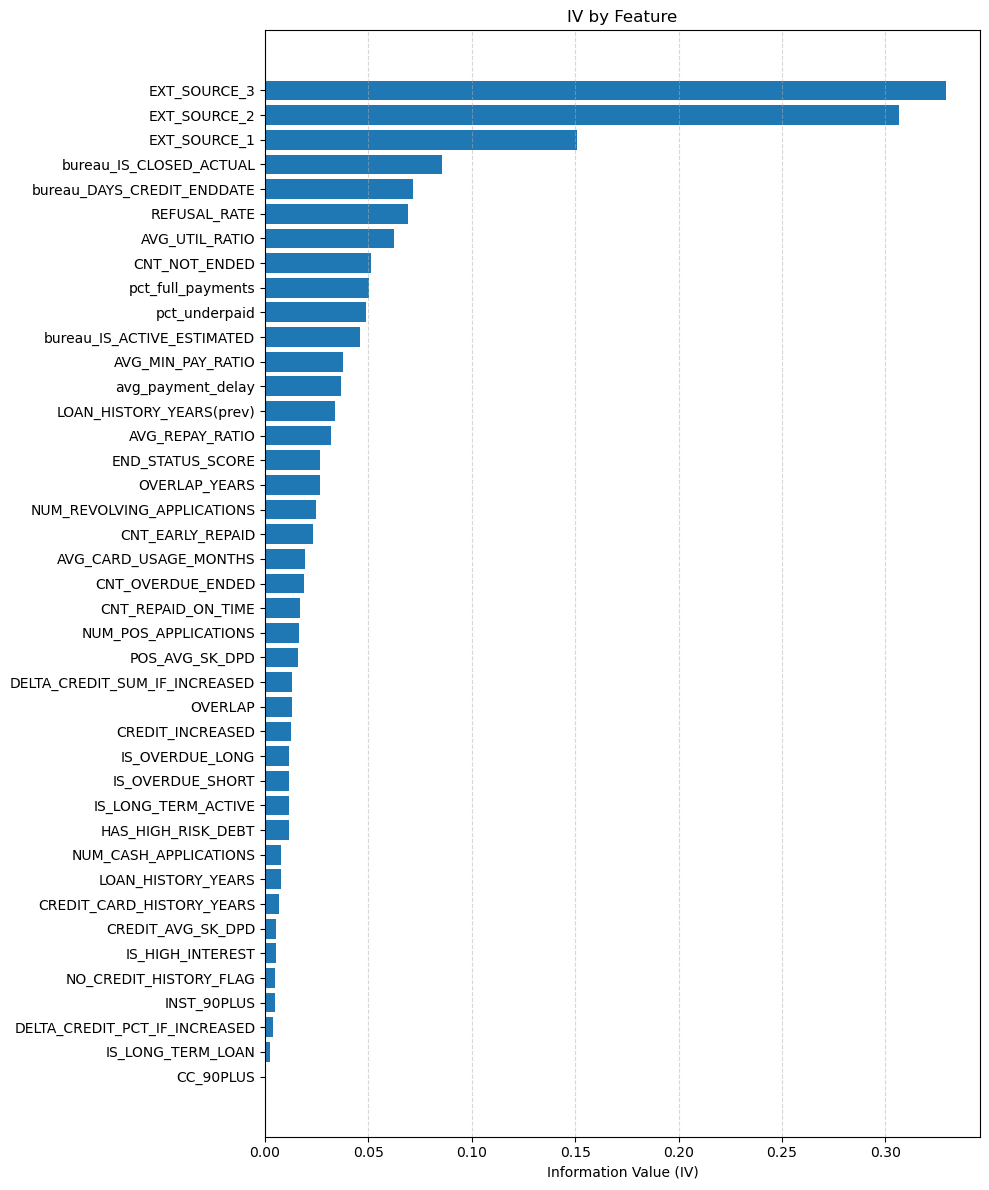

In [23]:
# IV 계산 및 시각화 준비
iv_summary = []
for feature in cont_cols + cat_cols:  # 사용 중인 feature 목록
    woe_iv_df, total_iv = calc_woe_iv(df, feature, target='TARGET')
    iv_summary.append((feature, total_iv))

# DataFrame으로 정리 및 시각화
iv_df = pd.DataFrame(iv_summary, columns=['Feature', 'IV']).sort_values(by='IV', ascending=False)

plt.figure(figsize=(10, 12))
plt.barh(iv_df['Feature'], iv_df['IV'])
plt.xlabel("Information Value (IV)")
plt.title("IV by Feature")
plt.gca().invert_yaxis()
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
